In [1]:
import sys
import os
sys.path.append(os.path.join(os.path.abspath(''), '../..'))

In [11]:
############################
#region Arguments

import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--save', type=str, default='./out.csv', help='save the outputs to csv')

# data args
parser.add_argument('--seed', type=int, default=123, help='Random seed for model')
parser.add_argument('--dataset', type=str, default='cora', help='dataset')
parser.add_argument('--protect_size', type=float, default=0.1, help='Number of randomly chosen protected nodes')

# attack args
parser.add_argument('--ptb_rate', type=float, default=0.25, help='Perturbation rate (percentage of available edges)')
parser.add_argument('--ptb_epochs', type=int, default=3, help='Epochs to perturb adj matrix')
parser.add_argument('--sample_size', type=int, default=50, help='')
parser.add_argument('--num_samples', type=int, default=2, help='')
parser.add_argument('--num_subtasks', type=int, default=30, help='')

# model args
parser.add_argument('--reg_epochs', type=int, default=10, help='Epochs to train models')
parser.add_argument('--model_lr', type=float, default=0.01, help='Initial learning rate')
parser.add_argument('--weight_decay', type=float, default=5e-4, help='Weight decay (L2 loss on parameters)')
parser.add_argument('--hidden_layers', type=int, default=32, help='Number of hidden layers')
parser.add_argument('--dropout', type=float, default=0.5, help='Dropout rate for GCN')


args = parser.parse_args("")

#endregion
##########################

##########################
#region Environment

import torch
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

np.random.seed(args.seed)
torch.manual_seed(args.seed)

if device != 'cpu':
    torch.cuda.manual_seed(args.seed)

print(f'[i] Environment:  torch {torch.__version__} \tdevice: {device} \tseed: {args.seed}')

#endregion
##########################

########################
#region Data

from Utils import GraphData

print(f'[i] Dataset: {args.dataset}')

graph = GraphData.getGraph("../../Datasets", args.dataset, "gcn", args.seed, device)
graph.summarize()

#endregion
########################

########################
#region Designate Protected

g0 = torch.rand(graph.features.shape[0]) <= args.protect_size
g0 = g0.to(device)
gX = ~g0
print(f"[i] Number of protected nodes: {g0.sum():.0f} ({g0.sum() / graph.features.shape[0]:.2%})")

#endregion
########################

########################
#region Sampling Matrix

from Utils import SamplingMatrix

samplingMatrix = SamplingMatrix.SamplingMatrix(g0, gX, graph.adj, args.sample_size)

#endregion
########################


[i] Environment:  torch 1.10.2 	device: cpu 	seed: 123
[i] Dataset: cora
Loading cora dataset...

[i] Dataset Summary: 
	adj shape: [2708, 2708]
	feature shape: [2708, 1433]
	num labels: 7
	split seed: 123
	train|val|test: 140|500|1000
[i] Number of protected nodes: 285 (10.52%)


Loading data for [cora_selected]
Failed to find data for [cora_selected]
Saving data for [cora_selected]


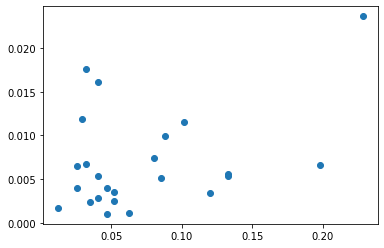

In [12]:
########################
#region Feature Selection

from Utils import FeatureMetrics
from Utils import Utils
from Utils import Export

metrics = Export.load_var("cora_selected")

if metrics == None:
    transposed = graph.features.t().contiguous()
    metrics = torch.zeros([3, transposed.shape[0]])

    for i in range(transposed.shape[0]):
        metrics[0][i] = i
        metrics[1][i] = FeatureMetrics.shannon_entropy(transposed[i])
        metrics[2][i] = FeatureMetrics.chi_squared(transposed[i], graph.labels)

    select_idx = FeatureMetrics.sample_by_quantiles(metrics[0], metrics[1], n_bins=4, n_samples=args.num_subtasks)
    metrics = metrics[:, select_idx == 1]
    Export.save_var("cora_selected", metrics.numpy().tolist())
else:
    metrics = torch.tensor(metrics)

import matplotlib.pyplot as plt
plt.scatter(metrics[1], metrics[2])

selected = Utils.idx_to_bool(metrics[0].long())

tasks = {
    -1: graph.labels
}
for i in Utils.bool_to_idx(selected):
    tasks[i.item()] = graph.features[:, i].squeeze()

#endregion
########################

In [ ]:
graph.features = graph.features[:,Utils.bool_to_idx(~selected)].squeeze()

In [4]:
########################
#region Do perturbation

from Models.GCN import GCN

surrogate = GCN(
    input_features=graph.features.shape[1],
    output_classes=graph.labels.max().item()+1,
    hidden_layers=args.hidden_layers,
    device=device,
    lr=args.model_lr,
    dropout=args.dropout,
    weight_decay=args.weight_decay,
    name=f"surrogate"
).to(device)

import torch.nn.functional as F
from tqdm import tqdm

perturbations = torch.zeros_like(graph.adj).float()
count = torch.zeros_like(graph.adj).float()
num_perturbations = args.ptb_rate * graph.adj.sum()

t = tqdm(range(args.ptb_epochs), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
t.set_description("Perturbing")

for epoch in t:

    # Re-initialize adj_grad
    adj_grad = torch.zeros_like(graph.adj).float()

    # Get modified adj
    modified_adj = Utils.get_modified_adj(graph.adj, perturbations).float().to(device)

    # Do sampling
    for sample_epoch in range(args.num_samples):
        # Get sample indices
        # sampled = torch.bernoulli(sampling_matrix)
        idx = samplingMatrix.get_sample()
        # print(idx)

        # Map sample to adj
        sample = modified_adj[idx[0], idx[1]].clone().detach().requires_grad_(True).to(device)
        modified_adj[idx[0], idx[1]] = sample

        # Get grad
        predictions = surrogate(graph.features, modified_adj)
        loss = F.cross_entropy(predictions[g0], graph.labels[g0]) \
            - F.cross_entropy(predictions[gX], graph.labels[gX])

        grad = torch.autograd.grad(loss, sample)[0]

        # Implement averaging
        adj_grad[idx[0], idx[1]] += grad
        count[idx[0], idx[1]] += 1

        # Update the sampling matrix
        samplingMatrix.updateByGrad(adj_grad, count)
        samplingMatrix.getRatio()

        # Average the gradient
        adj_grad = torch.div(adj_grad, count)
        adj_grad[adj_grad != adj_grad] = 0 # clear NaN
    
    # Update perturbations
    lr = (num_perturbations) / (epoch + 1)
    pre_projection = int(perturbations.sum() / 2)
    perturbations = perturbations + (lr * adj_grad)
    perturbations = Utils.projection(perturbations, num_perturbations)

    # Train the model
    modified_adj = Utils.get_modified_adj(graph.adj, perturbations)
    surrogate.train1epoch(graph.features, modified_adj, graph.labels, graph.idx_train, graph.idx_test)

    t.set_postfix({"adj_l": loss.item(),
                    "adj_g": int(adj_grad.sum()),
                    "pre-p": pre_projection,
                    "target": int(num_perturbations / 2),
                    "loss": loss})


#endregion
########################

Perturbing: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s, adj_l=0.00297, adj_g=0, pre-p=7, target=1319, loss=tensor(0.0030, grad_fn=<SubBackward0>)]


In [5]:
########################
#region Get sample

with torch.no_grad():

    max_loss = -1000

    for k in range(0,3):
        sample = torch.bernoulli(perturbations)
        modified_adj = Utils.get_modified_adj(graph.adj, perturbations)
        modified_adj = Utils.make_symmetric(modified_adj) # Removing this creates "impossible" adj, but works well

        predictions = surrogate(graph.features, modified_adj) 

        loss = F.cross_entropy(predictions[g0], graph.labels[g0]) \
            - F.cross_entropy(predictions[gX], graph.labels[gX])

        if loss > max_loss:
            max_loss = loss
            best = sample
    
    print(f"Best sample loss: {loss:.2f}\t Edges: {best.abs().sum() / 2:.0f}")

#endregion
########################

Best sample loss: 0.04	 Edges: 14


In [6]:
########################
#region Evaluation

def runtrial(adj, labels):
    """
    Return the accuracy over g0 and gX of a GCN trained using adj with respect to labels
    """
    model = GCN(
        input_features=graph.features.shape[1],
        output_classes=labels.max().item() + 1,
        hidden_layers=args.hidden_layers,
        device=device,
        lr=args.model_lr,
        dropout=args.dropout,
        weight_decay=args.weight_decay,
        name=f"baseline"
    ).to(device)

    model.fitManual(graph.features, adj, labels, graph.idx_train, graph.idx_test, args.reg_epochs, False)
    pred = model(graph.features, adj)
    acc_g0 = FeatureMetrics.categorical_accuracy(labels[g0], pred[g0].argmax(1))
    acc_gX = FeatureMetrics.categorical_accuracy(labels[gX], pred[gX].argmax(1))

    return acc_g0, acc_gX

locked_adj = Utils.get_modified_adj(graph.adj, best)
diff = locked_adj - graph.adj
edges = int(diff.abs().sum().item())

print(f"b_g0\tl_g0\tb_gX\tl_gX")
for task_idx in tasks:
    labels = FeatureMetrics.discretize(tasks[task_idx]).long()
    base_g0, base_gX = runtrial(graph.adj, labels)
    lock_g0, lock_gX = runtrial(locked_adj, labels)
    print(f"{base_g0:.1%}\t{lock_g0:.1%}\t{base_gX:.1%}\t{lock_gX:.1%}")

    row = {
        "seed": args.seed,
        "dataset": args.dataset,
        "protect_size": args.protect_size,
        "reg_epochs": args.reg_epochs,
        "ptb_epochs": args.ptb_epochs,
        "ptb_rate": args.ptb_rate,
        "ptb_sample_num": args.num_samples,
        "ptb_sample_size": args.sample_size,
        "task_idx": task_idx,
        "base_g0": base_g0,
        "base_gX": base_gX,
        "lock_g0": lock_g0,
        "lock_gX": lock_gX,
        "rel_g0": 1 - (lock_g0 / base_g0),
        "rel_gX": 1 - (lock_gX / base_gX),
        "edges": edges
    }
    
    if args.save != 'N':
        Export.saveData(args.save, row)

#endregion
########################

b_g0	l_g0	b_gX	l_gX
68.1%	66.0%	70.1%	69.7%


KeyboardInterrupt: 

In [ ]:
########################
#region Evaluation

from Utils import Export

print("==== Evaluation ====")
print(f"Task,\tG0,\tGX,\tD_G0\tD_GX")

locked_adj = Utils.get_modified_adj(graph.adj, best)
diff = locked_adj - graph.adj

for task_idx in range(selected_feat.shape[0]):
    temp_labels = tasks[t]["feat"].long()
    label_max = temp_labels.max().item() + 1

    baseline_model = GCN(
        input_features=graph.features.shape[1],
        output_classes=label_max,
        hidden_layers=args.hidden_layers,
        device=device,
        lr=args.model_lr,
        dropout=args.dropout,
        weight_decay=args.weight_decay,
        name=f"baseline"
    ).to(device)

    baseline_model.fitManual(graph.features, graph.adj, temp_labels, graph.idx_train, graph.idx_test, args.reg_epochs, False)

    pred = baseline_model(graph.features, graph.adj)
    baseline_acc = Metrics.partial_acc(pred, temp_labels, g0, gX, False)


    locked_model = GCN(
        input_features=graph.features.shape[1],
        output_classes=label_max,
        hidden_layers=args.hidden_layers,
        device=device,
        lr=args.model_lr,
        dropout=args.dropout,
        weight_decay=args.weight_decay,
        name=f"locked"
    )

    locked_model.fitManual(graph.features, locked_adj, temp_labels, graph.idx_train, graph.idx_test, args.reg_epochs, False)

    pred = locked_model(graph.features, locked_adj)
    locked_acc = Metrics.partial_acc(pred, temp_labels, g0, gX, False)

    dg0 = locked_acc["g0"] - baseline_acc["g0"]
    dgX = locked_acc["gX"] - baseline_acc["gX"]

    print(f"{t},\t{dg0:.1%},\t{dgX:.1%},\t{tasks[t]['ent']:.2f},\t{tasks[t]['corr']:.2f}")

    diffSummary = Metrics.show_metrics(diff, temp_labels, g0, device, False)

    results = {
        "seed": args.seed,
        "dataset": args.dataset,
        "protect_size": args.protect_size,
        "reg_epochs": args.reg_epochs,
        "ptb_epochs": args.ptb_epochs,
        "ptb_rate": args.ptb_rate,
        "ptb_sample_num": args.num_samples,
        "ptb_sample_size": args.sample_size,
        "ratio_g0": samplingMatrix.g0_ratio.item(),
        "ratio_gX": samplingMatrix.gX_ratio.item(),
        "ratio_g0gX": samplingMatrix.g0gX_ratio.item(),
        "feature": t,
        "corr": tasks[t]["corr"],
        "entropy": tasks[t]["ent"],
        "base_g0": baseline_acc["g0"],
        "base_gX": baseline_acc["gX"],
        "d_g0": dg0,
        "d_gX": dgX,
        "edges": int(diff.abs().sum().item()),
    }

    for add_remove in ["add", "remove"]:
        for location in ["g0", "gX", "g0gX"]:
            for similar in ["same", "diff"]:
                results["_".join([add_remove, location, similar])] = diffSummary[location][add_remove][similar]

    Export.saveData(args.save_location, results)

#endregion
########################
